In [1]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import pyplot
import pickle

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [15, 10]
pyplot.rcParams['figure.figsize'] = [15, 10]

In [2]:
x = pd.read_pickle('../Tables/feature_df.pkl')
y = pd.read_csv('../Tables/target_df.csv').drop(columns=['Unnamed: 0'])

### Model Setup
- train test split
- define xgboost train
- define xgboost test
- define hyperparameters

In [3]:
y['state'] = y['state'].replace({'successful': 1, 'failed': 0})

In [4]:
seed = 10
test_size = .3
x_train, x_test, y_train, y_test = train_test_split(x.drop(columns=['id']), y, test_size=test_size, random_state=seed)

In [5]:
x_train

,goal,campaign_length,prep_time,month_of_launch,weekday_of_launch,hour_of_launch,staff_pick,is_starrable,location_state_CA,location_state_England,location_state_FL,location_state_IL,location_state_MA,location_state_NY,location_state_Other,location_state_PA,location_state_TX,location_state_WA,country_AU,country_CA,country_DE,country_ES,country_FR,country_GB,country_IT,country_MX,country_Other,country_US,category_Classical Music,category_Dance,category_Graphic Novels,category_Jewelry,category_Narrative Film,category_Other,category_Performances,category_Poetry,category_Tabletop Games,category_Wearables
916,600.0,31,60,1,6,21,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
20066,7500.0,60,25,7,5,17,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
11567,250.0,14,20,5,2,18,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
2251,30000.0,33,107,10,6,8,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
21613,3000.0,16,14,4,3,3,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9372,16500.0,33,29,12,1,22,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
7291,50000.0,39,12,10,2,23,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False
17728,400.0,25,52,9,1,19,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
7293,25000.0,60,7,11,1,18,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True


In [6]:
y_train

,state
916,1
20066,1
11567,1
2251,1
21613,1
...,...
9372,0
7291,0
17728,1
7293,1


In [7]:
y_train['state'].value_counts()[0]

5416

In [8]:
x_train.to_pickle('../Tables/x_train.pkl')
x_test.to_pickle('../Tables/x_test.pkl')
y_train.to_pickle('../Tables/y_train.pkl')
y_test.to_pickle('../Tables/y_test.pkl')

In [9]:
# FROM PHIL: use base_score paramater to incorporate threshold tuning results

In [10]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': .05,
            'n_estimators':1000,
            'eval_metric': 'map'
        }        

model = XGBClassifier(**params)
model.fit(x_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='map', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [11]:
# 5 splits allows for enough data at each split while also being a sufficient number of folds for confidence in the resulting score
kfold = KFold(n_splits=5)
results = cross_val_score(model, x, y['state'], cv=kfold, scoring='precision')

In [12]:
#mean precision score from cross validation
results.mean()

0.8432572486538493

In [13]:
y_pred_proba = model.predict_proba(x_test)[:,1]

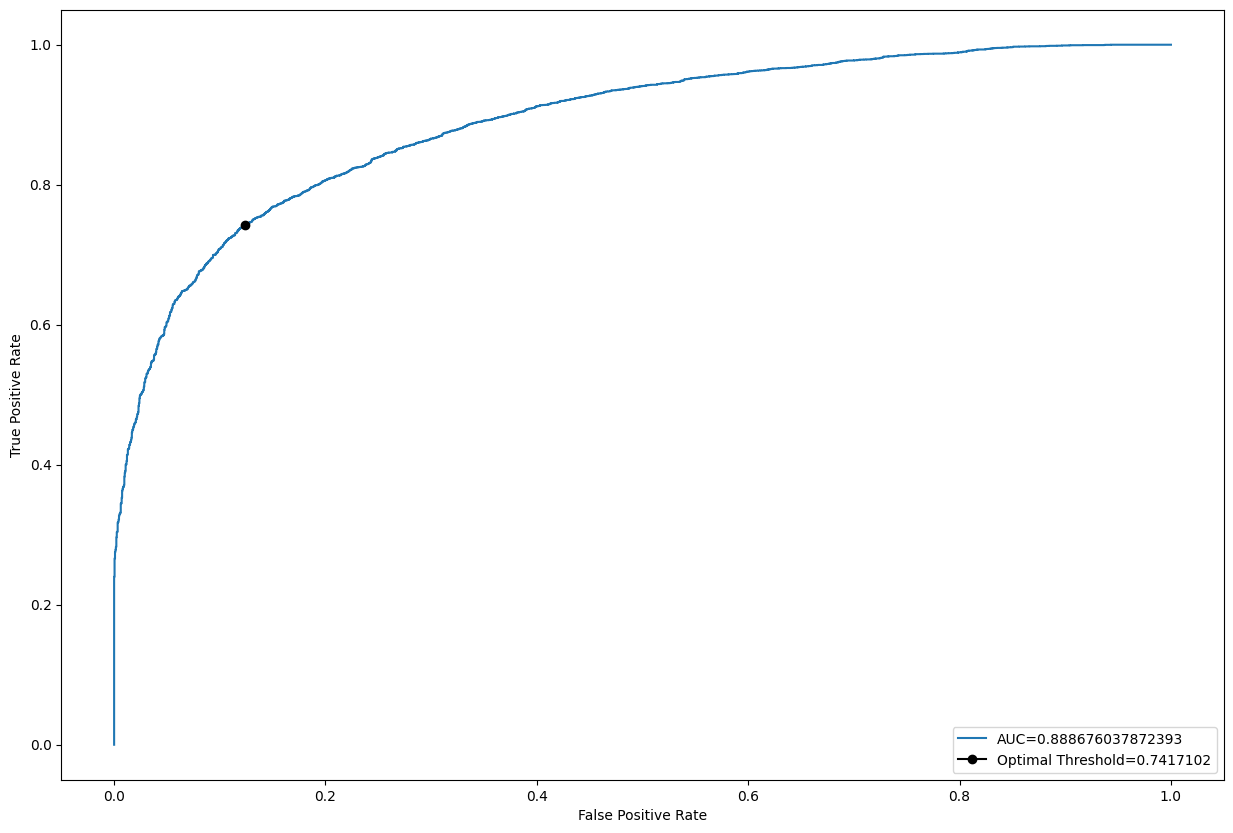

In [14]:
#Roc Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.auc(fpr, tpr)

# Youden's J statistic to find the optimal threshold value
j = tpr - fpr
ix = np.argmax(j)
best_threshold = thresholds[ix]

#plot the ROC with the optimal threshold labeled
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr[ix], tpr[ix], marker = 'o', color = 'black', label='Optimal Threshold='+str(best_threshold))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

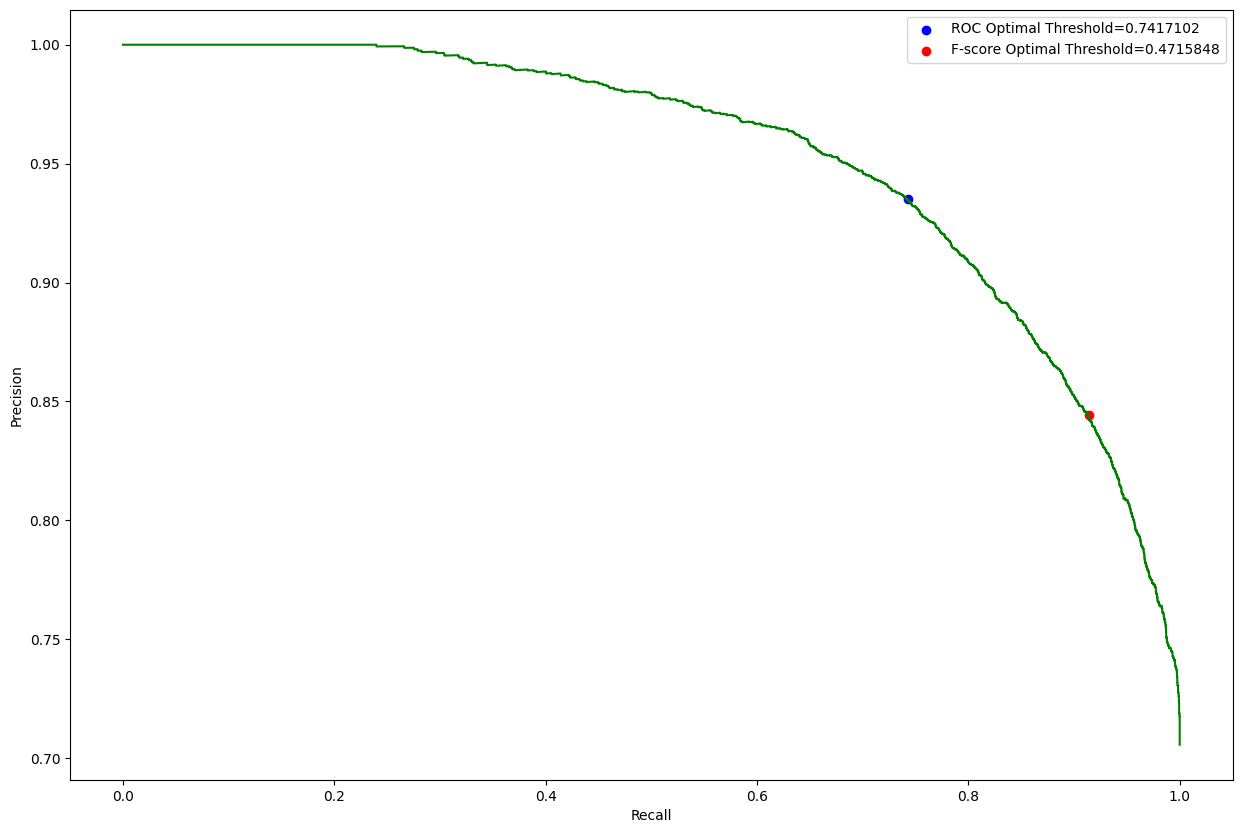

In [15]:
# Precision recall curve to test thresholds
# Compare AUC optimized threshold with F1 optimixed recall
# Since the goal of the model is precision, the one with the higher precision score will be selected
precision,recall,thresholds_f = metrics.precision_recall_curve(y_test,y_pred_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix_f = np.argmax(fscore)
index, = np.where(thresholds_f == best_threshold)

# Threshold from the ROC curve
best_threshold_roc = thresholds_f[index]
# Threshold to maximize f-score
best_threshold_f = thresholds_f[ix_f]

plt.plot(recall,precision, color='green')
plt.scatter(recall[index[0]], precision[index[0]], marker='o', color = 'blue', label='ROC Optimal Threshold='+str(best_threshold_roc[0]))
plt.scatter(recall[ix_f], precision[ix_f], marker='o', color = 'red', label='F-score Optimal Threshold='+str(best_threshold_f))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Since ROC Threshold is optimized for the ROC curve and has a high precision score, it will be used as the prediction threshold. In this classification problem, it is better to target a high precision score since we want to be sure that a project will actually be successul if it is predicted as successful

In [16]:
y_train_untuned_pred = model.predict(x_train)
train_precision_untuned = metrics.precision_score(y_train,y_train_untuned_pred)

In [17]:
y_train_tuned_pred = (model.predict_proba(x_train)[:,1] >= best_threshold_roc).astype(int)
train_precision_tuned = metrics.precision_score(y_train,y_train_tuned_pred)

In [18]:
print("TRAINING SET: untuned precision = "+str(train_precision_untuned)+", tuned_precision = "+str(train_precision_tuned)+". That is a gain of "+str(train_precision_tuned - train_precision_untuned)+"!")

TRAINING SET: untuned precision = 0.8596343769699517, tuned_precision = 0.9369035485963124. That is a gain of 0.07726917162636071!


In [19]:
y_test_untuned_pred = model.predict(x_test)
test_precision_untuned = metrics.precision_score(y_test,y_test_untuned_pred)

In [20]:
y_test_tuned_pred = (model.predict_proba(x_test)[:,1] >= best_threshold_roc).astype(int)
test_precision_tuned = metrics.precision_score(y_test,y_test_tuned_pred)

In [21]:
print("TESTING SET: untuned precision = "+str(test_precision_untuned)+", tuned_precision = "+str(test_precision_tuned)+". That is a gain of "+str(test_precision_tuned-test_precision_untuned)+"!")

TESTING SET: untuned precision = 0.8520543406229291, tuned_precision = 0.9350363356088968. That is a gain of 0.0829819949859677!


In [22]:
# Keeping local pickle integration

filename = '../Models/finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [23]:
# Get the current Workspace to register the model

from azureml.core import Workspace

ws = Workspace.get(name='kickstarter-v2',
               subscription_id='56b451c2-60d1-45a0-aae3-8622f9b01361',
               resource_group='DS-Practice',
               )

In [24]:
# Register the model for use as an endpoint to be called by other script

from azureml.core.model import Model

model = Model.register(model_path="../Models/finalized_model.pkl",
                       model_name="kickstarter-classifier",
                       tags={'area': "kickstarter", 'type': "classification"},
                       description="Classification model to predict successful kickstarter fundraisers",
                       workspace=ws)

Registering model kickstarter-classifier
